In [1]:
import cv2
import numpy as np
from utils import *
from segmentation import *

In [ ]:
def imageToWords(img):
    words = []
    lines = breakLines(img)
    for line in lines:
        line_words = breakWords(line)
        line_words.reverse()
        for word in line_words:
            words.append(word)
            
    return words

In [ ]:
letter_counts = {
    "ا" : 0,
    "ب" : 0,
    "ت" : 0,
    "ث" : 0,
    "ج" : 0,
    "ح" : 0,
    "خ" : 0,
    "د" : 0,
    "ذ" : 0,
    "ر" : 0,
    "ز" : 0,
    "ش" : 0,
    "س" : 0,
    "ص" : 0,
    "ض" : 0,
    "ط" : 0,
    "ظ" : 0,
    "ع" : 0,
    "غ" : 0,
    "ف" : 0,
    "ق" : 0,
    "ك" : 0,
    "ل" : 0,
    "م" : 0,
    "ن" : 0,
    "ه" : 0,
    "و" : 0,
    "ي" : 0,
    "ﻻ" : 0,
    "ى" : 0,
    "ئ" : 0,
    "ء" : 0,
    "ؤ" : 0,
    "ة" : 0
}

In [ ]:
def imgToDataSet(img_path, text_path):
    img = cv2.imread(img_path)
    img_words = imageToWords(img)
    with open(text_path) as f:
        text = f.readlines()[0]
        text_words = text.split()
        index = 0
        for word in text_words:
            if index >= len(img_words):
                break
            chars = segmenteCharacters(img_words[index])
            if len(chars) == len(word):
                chars.reverse()
                for i in range(len(word)):
                    letter = 255*extractTemplate(chars[i])
                    if letter.shape[0] < 25 and letter.shape[1] < 25:
                        mask = np.zeros((25, 25))

                        vertical_start = int((25 - letter.shape[0]) / 2)
                        vertical_end = vertical_start + letter.shape[0]
                        horizontal_start = int((25 - letter.shape[1]) / 2)
                        horizontal_end = horizontal_start + letter.shape[1]

                        mask[vertical_start:vertical_end, horizontal_start:horizontal_end] = letter
                        cv2.imwrite("./DataSets/dataSet/" + word[i] + "/" + word[i] + "_" + str(letter_counts[word[i]]) + ".png", mask)
                        letter_counts[word[i]] += 1
            index += 1

In [ ]:
count = 10
img_path = "./DataSets/sample/test" + str(count) + "/test" + str(count) + ".png"
text_path = "./DataSets/sample/test" + str(count) + "/test" + str(count) + ".txt"
imgToDataSet(img_path, text_path)

In [2]:
img_path = "./DataSets/sens.png"
img = cv2.imread(img_path)
lines = breakLines(img)
line_0 = breakWords(lines[0])
line_1 = breakWords(lines[1])
line_2 = breakWords(lines[2])
words = []
for word in line_0:
    words.append(word)
for word in line_1:
    words.append(word)
for word in line_2:
    words.append(word)

In [ ]:
sen1 = (cv2.imread("./templates/sen_template.png", 0) / 255).astype(np.uint8)
sen2 = (cv2.imread("./templates/sen_middle_template.png", 0) / 255).astype(np.uint8)

In [ ]:
def test(skeleton, template, threshold=0.4, start=False):
    if template.shape[0] > skeleton.shape[0] or template.shape[1] > skeleton.shape[1]:
        return 0

    img_rgb = cv2.cvtColor((255 * skeleton).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    w, h = template.shape[::-1]
    res = cv2.matchTemplate(skeleton.astype(np.uint8),
                            template.astype(np.uint8), cv2.TM_CCOEFF_NORMED)
    loc = np.where(res >= threshold)

    for pt in zip(*loc[::-1]):
        cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 1)

    return img_rgb

In [ ]:
def compareHist(skeleton, template, threshold=0.4):
    if template.shape[0] > skeleton.shape[0] or template.shape[1] > skeleton.shape[1]:
        return 0

    w, h = template.shape[::-1]
    res = cv2.matchTemplate(skeleton.astype(np.uint8),
                            template.astype(np.uint8), cv2.TM_CCOEFF_NORMED)
    result = (res >= threshold) + 0
    
    show_images([result])
    senHist = getHist(template)
    wordHist = getHist(result)

    maybe = []
    for i in range(len(wordHist)-9):
        distance = np.sum(abs(wordHist[i:i+10] - senHist))
        if distance < 5:
            maybe.append((i, distance))

#     print(maybe)
    minDistance = 5
    splitter = None
    for window in maybe:
        if window[1] < minDistance:
            minDistance = window[1]
            splitter = window[0]

    bgr_skeleton = cv2.cvtColor((255 * (skeleton + 0)).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    if splitter != None:
        cv2.line(bgr_skeleton, (splitter, 0), (splitter, bgr_skeleton.shape[1]), (255, 0, 0), 1)
        cv2.line(bgr_skeleton, (splitter+9, 0), (splitter+9, bgr_skeleton.shape[1]), (255, 0, 0), 1)

    return bgr_skeleton

In [63]:
def removeDots(word):
    skeleton = toSkeleton(word)
    skeleton = skeleton.astype(np.uint8)

    #find contours
    ctrs, hier = cv2.findContours(skeleton.copy(), cv2.RETR_EXTERNAL, 
    cv2.CHAIN_APPROX_SIMPLE)

    # #sort contours
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

    dots = []
    for i, ctr in enumerate(sorted_ctrs):
        x, y, w, h = cv2.boundingRect(ctr)
        if w < 5 and h < 5:
            skeleton[y:y+h, x:x+w] = 0
            dots.append((x, w))
            
    return [skeleton, dots]

In [56]:
def getHeight(skeleton, index):
    indecies = np.where(skeleton[:, index] == 1)[0]
    if len(indecies) > 0:
        return abs(indecies.min() - indecies.max())

    return 0

In [116]:
def matchSen(word):
    skeleton, dots = removeDots(word)
    
    uppers = []
    for i in range(skeleton.shape[1]):
        column = skeleton[:, i]
        if np.sum(column) != 0:
            uppers.append(skeleton.shape[0] - np.where(skeleton[:, i] == 1)[0].min())
        else:
            uppers.append(skeleton.shape[0])
    
    diff = np.diff(uppers)
    peaks = []
    for i in range(len(diff)-11):
        is_peak = False
        possible_peaks = []
        for j in range(11):
            if diff[i+j-1] > 0:
                is_peak = True
            if diff[i+j-1] < 0 and is_peak and getHeight(skeleton, i+j-1) <= 4:
                is_peak = False
                possible_peaks.append(i+j-1)

        valid_window = True
        if len(possible_peaks) > 2:
            for i in range(possible_peaks[0], possible_peaks[-1]):
                if np.sum(skeleton[:, i]) <= 0:
                    valid_window = False
                    break
            
            if valid_window:
                for peak in possible_peaks:
                    peaks.append(peak)

    peaks = list(set(peaks))
    mod_peaks = []
    if len(peaks) % 3 != 0:
        for peak in peaks:
            valid = True
            for dot in dots:
                if peak >= dot[0] and peak <= dot[0]+dot[1]:
                    valid = False

            if valid:
                mod_peaks.append(peak)   
    else:
        mod_peaks = peaks
    
    mod_peaks.sort()
    sens = []
    for i in range(0, len(mod_peaks)-2, 3):
        if i+3 <= len(mod_peaks):
            sens.append(mod_peaks[i:i+3])

    splitters = []
    for sen in sens:
        splitters.append(sen[0]-2)
        splitters.append(sen[-1]+2)
    
    return splitters

In [125]:
def segmenteCharacters(word, to_skeleton=True, debug=False):
    full_skeleton = toSkeleton(word) if to_skeleton else word
    skeleton = toSkeleton(word) if to_skeleton else word
    base_line = getBaseLine(skeleton)
    splitters = np.array([]).astype(np.uint8)

    first_sep = matchFirstCharacter(word)
    if first_sep >= word.shape[1]:
        return [full_skeleton]

    if first_sep != 0:
        splitters = np.append(splitters, first_sep)
        word = word[:, first_sep:]
        skeleton = toSkeleton(word)

    full_hist = getHist(skeleton)
    hist = getHist(skeleton[0:base_line-1, :])
    diff = np.diff(hist)

    # add splitters at the start of region that doesn't contain pixels
    empty_space_splitters = addEmptySpaceSep(full_hist) + first_sep
    splitters = np.append(np.array(splitters), empty_space_splitters)
    
    # add sen and shen splitters
    sen_splitters = np.array(matchSen(word)) + first_sep
    splitters = np.append(splitters, sen_splitters)
    
    # add splitter at point if you were above base line and return back to baseline
    base_line_splitters = []
    for i in range(1, len(diff)):
        if diff[i-1] != 0 and diff[i] == 0 and hist[i] == 0:
            for j in range(0, len(sen_splitters), 2):
                if not ((i + first_sep) >= sen_splitters[j] and (i + first_sep) <= sen_splitters[j+1]):
                    if abs((i + first_sep) - sen_splitters[j]) > 3 and abs((i + first_sep) - sen_splitters[j+1]) > 3:
                        base_line_splitters.append(i + first_sep)

    splitters = np.append(splitters, base_line_splitters).astype(np.uint8)
    splitters.sort()    # sort splitters in ascending order
    
    if len(splitters) == 0:
        return [full_skeleton]

    start = 2 if len(
        splitters) > 1 and splitters[1] - splitters[0] <= 3 and splitters[1] in empty_space_splitters else 1
    mod_splitters = np.array(
        [splitters[1] if start == 2 else splitters[0]]).astype(np.uint8)
    real_splitters = [splitters[i] for i in range(
        start, len(splitters)) if splitters[i] - splitters[i-1] > 3]
    mod_splitters = np.append(mod_splitters, real_splitters).astype(np.uint8)
    
    if len(mod_splitters) == 0:
        return [full_skeleton]

    # remove separators with no characters between them
    non_character_filtered = []
    for i in range(len(mod_splitters)-1):
        sub_hist = full_hist[mod_splitters[i] -
                             first_sep:mod_splitters[i+1]-first_sep]
        if np.sum((sub_hist > 1) + 0) > 0:
            non_character_filtered.append(mod_splitters[i])
    if np.sum(full_hist[mod_splitters[-1]-first_sep:]) > 0:
        non_character_filtered.append(mod_splitters[-1])

    if len(non_character_filtered) == 0:
        return [full_skeleton]

    # remove fake alef at the beginning
    start = 1 if isFakeAlef(skeleton, non_character_filtered[0]) else 0
    fake_alef_splitter_filtered = np.array(
        non_character_filtered[start:]).astype(np.uint8)

    if len(fake_alef_splitter_filtered) == 0:
        return [full_skeleton]

    if debug:
        bgr_skeleton = cv2.cvtColor(
            (255 * full_skeleton).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        for splitter in fake_alef_splitter_filtered:
            cv2.line(bgr_skeleton, (splitter, 0), (splitter,
                                                   bgr_skeleton.shape[1]), (255, 0, 0), 1)

        return bgr_skeleton
    else:
        characters = []
        characters.append(full_skeleton[:, 0:fake_alef_splitter_filtered[0]])
        for i in range(len(fake_alef_splitter_filtered)-1):
            characters.append(
                full_skeleton[:, fake_alef_splitter_filtered[i]:fake_alef_splitter_filtered[i+1]])
        characters.append(full_skeleton[:, fake_alef_splitter_filtered[-1]:])

        return characters

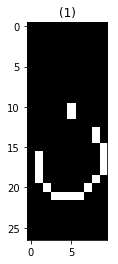

In [128]:
word = words[0]
chars = segmenteCharacters(word)
show_images([np.concatenate((chars[0], chars[1]), axis=1)])

In [7]:
# for word in words:
#     show_images([word, cv2.Canny(word,100,200)])
#     compareHist(toSkeleton(word), sen1)
#     show_images([toSkeleton(word), matchSen(toSkeleton(word))])

In [ ]:
skeleton = toSkeleton(words[0])
nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(skeleton, None, None, None, 8, cv2.CV_32S)
sizes = stats[1:, -1] #get CC_STAT_AREA component
img2 = np.zeros((labels.shape), np.uint8)

for i in range(0, nlabels - 1):
    if sizes[i] >= 50:   #filter small dotted regions
        img2[labels == i + 1] = 255

res = cv2.bitwise_not(img2)
show_images([skeleton, res])